In [23]:
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
import re
from collections import Counter
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import add
from keras.layers import concatenate
from keras.layers import Concatenate
from keras.layers import Input
from keras.layers import Conv1D,Convolution1D
from keras.layers import MaxPool1D,MaxPooling1D
from keras.layers import SpatialDropout1D
from keras.optimizers import Adam
from keras.objectives import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.layers import Merge
from keras.layers.recurrent import LSTM
import numpy as Math
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn.manifold import TSNE

In [46]:
import os
def read_files(foldername):
    import os
    sentiments = []
    filenames = os.listdir(os.curdir+ "/"+foldername)
    for file in filenames:
        with open(foldername+"/"+file,"r", encoding="utf8") as pos_file:
            data=pos_file.read().replace('\n', '')
            sentiments.append(data)
    return sentiments
    
    
foldername = "easy/pos"
postive_sentiment = read_files(foldername)

foldername = "easy/neg"
negative_sentiment = read_files(foldername)

positive_labels = [1 for _ in postive_sentiment]
negative_labels = [0 for _ in negative_sentiment]

In [47]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ", string)
    string = re.sub(r"\)", " ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r",", " ", string)
    string = re.sub(r"'", " ", string)
    string = re.sub(r"\[", " ", string)
    string = re.sub(r"\]", " ", string)
    return string.strip().lower()

In [48]:
# word_dict = {}
# word_counter = Counter()
# def create_count(sentiments):
#     idx = 0
#     for line in sentiments:
#         for word in (clean_str(line)).split():
#             if word not in word_dict.keys():               
#                 word_counter[word] = 1
#                 word_dict[word] = idx
#                 idx+=1
#             else:
#                 word_counter[word] += 1


# model_path = "../models/"
# all_sentiments = postive_sentiment + negative_sentiment
# create_count(all_sentiments)
# idx2word = {v: k for k, v in word_dict.items()}

word_counter = Counter()
def create_count(sentiments):
    idx = 0
    for line in sentiments:
        for word in (clean_str(line)).split():
            if word not in word_counter.keys():               
                word_counter[word] = 1
            else:
                word_counter[word] += 1

def create_word_index():
    idx = 0
    word_dict = {}
    for word in word_counter.most_common():
        word_dict[word[0]] = idx
        idx+=1
    return word_dict
    


model_path = "../models/"
all_sentiments = postive_sentiment + negative_sentiment
all_labels = positive_labels + negative_labels
create_count(all_sentiments)
word_dict = create_word_index()
idx2word = {v: k for k, v in word_dict.items()}



In [98]:
def encoded_sentences(input_file,word_dict):
    output_string = []
    for line in input_file:
        output_line = []
        for word in (clean_str(line)).split():
            output_line.append(word_dict[word])
        output_string.append(output_line)
    return output_string

def decode_sentences(input_file,word_dict):
    output_string = []
    for line in input_file:
        output_line = ''
        for idx in line:
            output_line += idx2word[idx] + ' '
        output_string.append(output_line)
    return output_string

def pad_sequences(sentences,maxlen=500,value=0):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    padded_sentences = []
    for sen in sentences:
        new_sentence = []
        if(len(sen) > maxlen):
            new_sentence = sen[:maxlen]
            padded_sentences.append(new_sentence)
        else:
            num_padding = maxlen - len(sen)
            new_sentence = np.append(sen,[value] * num_padding)
            padded_sentences.append(new_sentence)
    return padded_sentences

In [50]:
positive_encoded = encoded_sentences(postive_sentiment,word_dict)
negative_encoded = encoded_sentences(negative_sentiment,word_dict)

all_encoded = positive_encoded + negative_encoded

In [51]:
vocab_size = 5000
seq_len = 500
embedding_dim = 50

#trn = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in train_set]
#test = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in test_set]
t_data = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in all_encoded]

In [52]:
X_train_val, X_test, y_train_val, y_test = train_test_split(t_data, all_labels, test_size=0.3, random_state=42)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

In [54]:
min_len = min(map(len, t_data))
max_len = max(map(len,t_data))
avg_len = sum(map(len,t_data)) / len(t_data)
print("the minimum length is:",min_len)
print("the maximum length is:",max_len)
print("the average length is:",avg_len)

the minimum length is: 10
the maximum length is: 2564
the average length is: 245.28632


In [103]:
# trn = sequence.pad_sequences(X_train, maxlen=seq_len, value=0)
# val = sequence.pad_sequences(X_val, maxlen=seq_len, value=0)
# test = sequence.pad_sequences(X_test, maxlen=seq_len, value=0)

trn = np.array(pad_sequences(X_train, maxlen=seq_len, value=0))
val = np.array(pad_sequences(X_val, maxlen=seq_len, value=0))
test = np.array(pad_sequences(X_test, maxlen=seq_len, value=0))

In [104]:
dense_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=seq_len),
    Flatten(),
    Dense(1, activation='relu')])

In [105]:
dense_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 50)           250000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 25000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25001     
Total params: 275,001
Trainable params: 275,001
Non-trainable params: 0
_________________________________________________________________


In [106]:
dense_model.fit(trn, y_train, validation_data=(val, y_val), epochs=5, batch_size=64)
dense_model.save_weights("model/dense.h5")

Train on 12250 samples, validate on 5250 samples
Epoch 1/5
12250/12250 [==============================] - 1s - loss: 0.7631 - acc: 0.5695 - val_loss: 0.6206 - val_acc: 0.7050
Epoch 2/5
12250/12250 [==============================] - 1s - loss: 0.4576 - acc: 0.8310 - val_loss: 0.4269 - val_acc: 0.8371
Epoch 3/5
12250/12250 [==============================] - 1s - loss: 0.2501 - acc: 0.9021 - val_loss: 0.4569 - val_acc: 0.8446
Epoch 4/5
12250/12250 [==============================] - 1s - loss: 0.1457 - acc: 0.9173 - val_loss: 0.4834 - val_acc: 0.8240
Epoch 5/5
12250/12250 [==============================] - 1s - loss: 0.0830 - acc: 0.9078 - val_loss: 0.5377 - val_acc: 0.7897


In [62]:
dense_model.load_weights("model/dense.h5")

In [63]:
weights = dense_model.get_weights()
#print(weights[1][1])
dense_model.get_config()
print(len(weights[0]))
print((weights[0]))
idx2word[1]

5000
[[-0.00239288 -0.01767137 -0.02746839 ..., -0.02318721 -0.00642159
  -0.02290398]
 [-0.00600406  0.00443663 -0.03258764 ...,  0.01854093  0.02275047
   0.03073082]
 [-0.01933826  0.0009991   0.02818683 ..., -0.00352166  0.01050212
   0.03621733]
 ..., 
 [ 0.05159397 -0.09803655 -0.02393755 ...,  0.00204469  0.02954685
   0.05481454]
 [-0.03628892  0.0141897  -0.04213191 ...,  0.0391539  -0.02609709
   0.13599665]
 [-0.01367764 -0.00889422  0.02013562 ..., -0.04143726  0.03607545
  -0.00659699]]


'and'

<IPython.core.display.Javascript object>


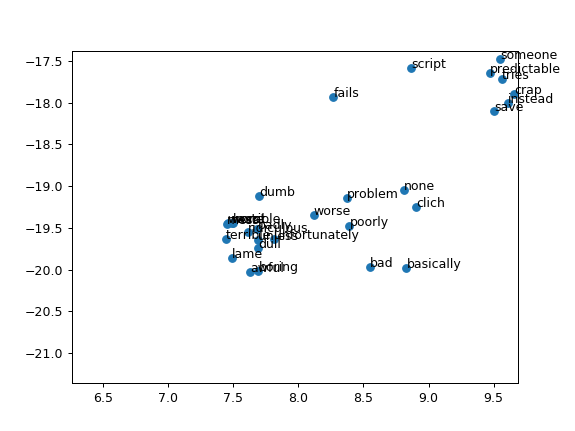

In [61]:
tsne = TSNE(n_components=2, random_state=0)
size = 1000
Y = tsne.fit_transform(weights[0][:size,:])
plt.scatter(Y[:, 0], Y[:, 1])
for idx, (x, y) in enumerate(zip(Y[:, 0], Y[:, 1])):
    plt.annotate(idx2word[idx], xy=(x, y), xytext=(0, 0), textcoords='offset points')
    

In [110]:
loss_and_metrics = dense_model.evaluate(test, y_test, batch_size=64);
print("the accuracy on test set is:",loss_and_metrics[1])

7424/7500 [============================>.] - ETA: 0sthe accuracy on test set is: 0.794666666667


In [121]:
conv1 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=seq_len),
    SpatialDropout1D(0.4),
    Convolution1D(64, 5, padding='same', activation='relu'),
    Dropout(0.4),
    MaxPooling1D(),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')])

In [122]:
conv1.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [123]:
conv1.fit(trn, y_train, validation_data=(val, y_val), epochs=10, batch_size=64)

Train on 12250 samples, validate on 5250 samples
Epoch 1/10
12250/12250 [==============================] - 7s - loss: 0.5856 - acc: 0.6527 - val_loss: 0.3425 - val_acc: 0.8533
Epoch 2/10
12250/12250 [==============================] - 7s - loss: 0.2839 - acc: 0.8904 - val_loss: 0.2919 - val_acc: 0.8827
Epoch 3/10
12250/12250 [==============================] - 7s - loss: 0.1948 - acc: 0.9270 - val_loss: 0.2881 - val_acc: 0.8802
Epoch 4/10
12250/12250 [==============================] - 7s - loss: 0.1530 - acc: 0.9451 - val_loss: 0.3433 - val_acc: 0.8630
Epoch 5/10
12250/12250 [==============================] - 7s - loss: 0.1083 - acc: 0.9607 - val_loss: 0.3911 - val_acc: 0.8636
Epoch 6/10
12250/12250 [==============================] - 7s - loss: 0.0763 - acc: 0.9736 - val_loss: 0.4551 - val_acc: 0.8629
Epoch 7/10
12250/12250 [==============================] - 7s - loss: 0.0675 - acc: 0.9749 - val_loss: 0.4508 - val_acc: 0.8693
Epoch 8/10
12250/12250 [==============================] - 7s -

In [124]:
loss_and_metrics = conv1.evaluate(test, y_test, batch_size=64);
print("the accuracy on test set is:",loss_and_metrics[1])

7488/7500 [============================>.] - ETA: 0sthe accuracy on test set is: 0.870266666667


In [125]:
conv1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 50)           250000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 500, 50)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 500, 64)           16064     
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 16000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               3200200   
__________

In [109]:
graph_in = Input((vocab_size, embedding_dim))
convs = [ ] 
for fsz in range (3, 6): 
    x = Convolution1D(64, fsz, padding='same', activation="relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)
out = concatenate(convs) 
graph = Model(graph_in, out)

In [ ]:
conv1_multiple = Sequential ([
    Embedding(vocab_size, embedding_dim, input_length=seq_len),
    SpatialDropout1D(0.2),
    graph,
    Dropout (0.5),
    Dense (100, activation="relu"),
    Dropout (0.3),
    Dense (1, activation='sigmoid')
    ])

In [107]:
conv1_multiple.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
conv1_multiple.summary()

NameError: name 'conv1_multiple' is not defined

In [ ]:
conv1_multiple.fit(trn, y_train, validation_data=(val, y_val), epochs=10, batch_size=64)

In [ ]:
loss_and_metrics = conv1_multiple.evaluate(test, y_test, batch_size=64);
print("the accuracy on test set is:",loss_and_metrics[1])

In [12]:
def load_glove_index(loc):
    f = open(loc,encoding="utf8")
    embeddings_index = {}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

def create_emb():
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_dict.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
embeddings_index = load_glove_index("glove/" + 'glove.6B.50d.txt')
embedding_matrix = create_emb();

In [ ]:
conv1_multiple_embedding = Sequential ([
    Embedding(vocab_size, embedding_dim, input_length=seq_len,weights=[embedding_matrix],trainable=False),
    SpatialDropout1D(0.2),
    graph,
    Dropout (0.3),
    Dense (200, activation="relu"),
    Dropout (0.3),
    Dense (1, activation='sigmoid')
    ])

In [ ]:
conv1_multiple_embedding.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
conv1_multiple_embedding.fit(trn, y_train, validation_data=(val, y_val), epochs=14, batch_size=64)

In [ ]:
loss_and_metrics = conv1_multiple_embedding.evaluate(test, y_test, batch_size=64);
print("the accuracy on test set is:",loss_and_metrics[1])

In [ ]:
conv1_embed = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=seq_len,weights=[embedding_matrix]),
    SpatialDropout1D(0.4),
    Convolution1D(64, 5, padding='same', activation='relu'),
    Dropout(0.4),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')])

In [ ]:
conv1_embed.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
conv1_embed.fit(trn, y_train, validation_data=(val, y_val), epochs=12, batch_size=64)

In [ ]:
loss_and_metrics = conv1_embed.evaluate(test, y_test, batch_size=64);
print("the accuracy on test set is:",loss_and_metrics[1])

<IPython.core.display.Javascript object>


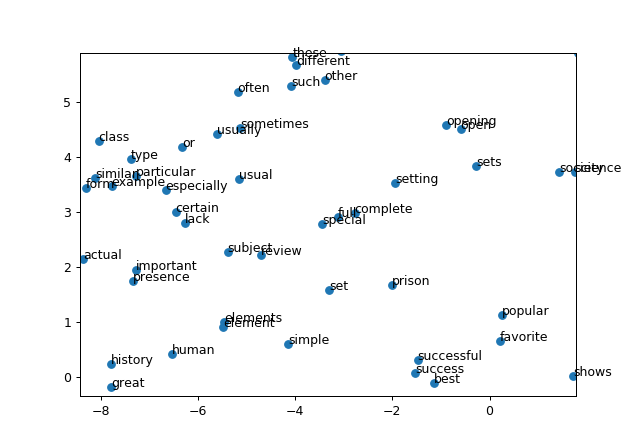

In [22]:
tsne = TSNE(n_components=2, random_state=0)
size = 1000
Y = tsne.fit_transform(embedding_matrix[:size,:])
plt.scatter(Y[:, 0], Y[:, 1])
for idx, (x, y) in enumerate(zip(Y[:, 0], Y[:, 1])):
    plt.annotate(idx2word[idx], xy=(x, y), xytext=(0, 0), textcoords='offset points')





In [20]:
plt.plot()

